In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy
from brian2.units import *
%matplotlib inline
plt.viridis()
from matplotlib import animation, rc
from IPython.display import HTML

In [69]:
folder = "./2017-07-30-12-27-57-930000/run_1/provenance_data/"

In [74]:
files = !ls *.txt

In [75]:
files

['The system cannot find the path specified.',
 'ls: 0_0_*.txt: No such file or directory']

In [148]:
open_files = []
eof = []
for f in files:
    open_files.append(open(f, "r"))  
    eof.append(False)
print len(open_files), "files"


11 files


In [149]:
# Initial file alignment
for of in open_files:
    for line in of:
        if "[INFO]    (src/simulation.c: 139): Resuming" in line:
            break

In [150]:
timeline = {'form':[],
            'del':[],
            'nop':[]}

In [152]:
# while not all(eof):
for i in range(len(open_files)):
    for line in open_files[i]:
        if not line:
            eof[i] = True

        if "NO FORM" in line or "OOB" in line or "FAIL" in line:
            timeline['nop'].append((files[i], int(line[::-1].split(" ")[0][::-1])))
        elif "FORM" in line:
            l = line[str.index(line, "pre"):-1].split()
            timeline['form'].append((files[i], int(line[::-1].split(" ")[0][::-1]), 
                                     "pre", int(l[1]), 
                                     "post", int(l[3]),
                                     "controls", int(l[6])))
        elif "RM" in line:
            l = line[str.index(line, "pre"):-1].split()
            timeline['del'].append((files[i], int(line[::-1].split(" ")[0][::-1]), 
                                     "pre", int(l[1]), 
                                     "post", int(l[3]),
                                     "controls", int(l[6])))
timeline['form'] = sorted(timeline['form'], key=lambda tup: tup[1])
timeline['del']  = sorted(timeline['del'],  key=lambda tup: tup[1])
timeline['nop']  = sorted(timeline['nop'],  key=lambda tup: tup[1])          

In [157]:
len(timeline['form'])

2630

In [174]:
hit_map = np.zeros((256,256))
for forms in timeline['form']:
    hit_map[forms[3], forms[5]] += 1

for dels in timeline['del']:
    hit_map[forms[3], forms[5]] += 1
    
hit_map = np.log(hit_map)

WARNING    c:\python27\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in log
 [py.warnings]


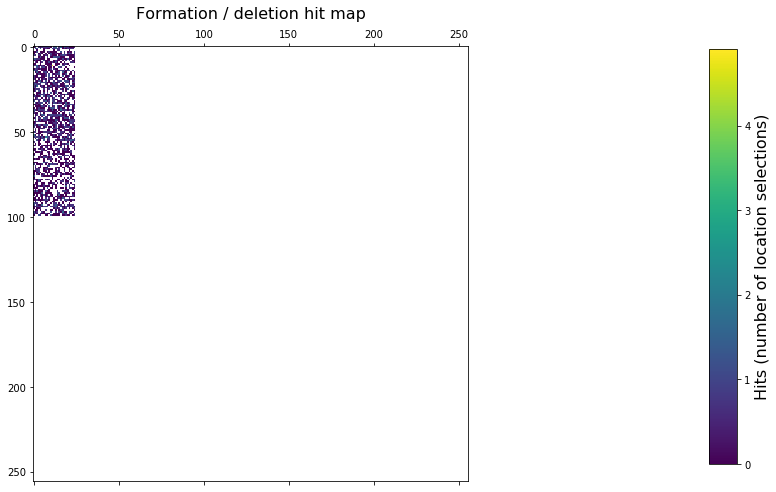

In [175]:
f, ax1 = plt.subplots(1, 1, figsize=(16, 8))
i = ax1.matshow(hit_map)
ax1.grid(visible=False)
ax1.set_title("Formation / deletion hit map", fontsize=16)
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("Hits (number of location selections)", fontsize=16)


In [168]:
np.max(hit_map)

135.0

In [62]:
def distance(x0, x1, grid=np.asarray([16, 16]), type='euclidian'):
    print "source", x0
    print "target", x1
    print "grid", grid
    x0 = np.asarray(x0)
    x1 = np.asarray(x1)
    delta = np.abs(x0 - x1)
    print "delta initial", delta
    delta = np.where(delta > grid * .5, delta - grid, delta)
    print "delta after", delta

    if type == 'manhattan':
        return np.abs(delta).sum(axis=-1)
    return np.sqrt((delta ** 2).sum(axis=-1))

In [63]:
grid = np.asarray([7,7])

In [66]:
def index_to_dist(i1, i2, grid):
    return distance((i1//grid[0], i1%grid[1]),(i2//grid[0], i2%grid[1]), grid=grid, type='euclidian')

In [68]:
index_to_dist(11,1, grid)**2

source (1, 4)
target (0, 1)
grid [7 7]
delta initial [1 3]
delta after [1 3]


10.000000000000002

In [60]:
def my_abs(a):
    if a < 0:
        return -a 
    else:
        return a

In [61]:
pre_global_id = 44
post_global_id = 34


pre_x = pre_global_id / grid[0]
pre_y = pre_global_id % grid[1]

post_x = post_global_id / grid[0]
post_y = post_global_id % grid[1]


delta_x = my_abs(pre_x - post_x)
delta_y = my_abs(pre_y - post_y)
print "my delta initial [", delta_x, delta_y, "]"

if( delta_x > (grid[0]>>1) ):
    delta_x -= grid[0];

if( delta_y > (grid[1]>>1) ):
    delta_y -= grid[1];
print "my delta after", delta_x, delta_y

print delta_x*delta_x + delta_y*delta_y;

my delta initial [ 2 4 ]
my delta after 2 -3
13


# Checking random number generation

In [317]:
files = !cd provenance & ls *.txt
print files

['1_0_10.txt', '1_0_11.txt', '1_0_12.txt', '1_0_13.txt', '1_0_14.txt', '1_0_15.txt', '1_0_2.txt', '1_0_3.txt', '1_0_4.txt', '1_0_5.txt', '1_0_6.txt', '1_0_7.txt', '1_0_8.txt', '1_0_9.txt']


In [318]:
open_files = []
eof = []
for f in files:
    open_files.append(open(f, "r"))  
    eof.append(False)
print len(open_files), "files"

14 files


In [319]:
# Initial file alignment
for of in open_files:
    for line in of:
        if "[INFO]    (src/simulation.c: 153): Resuming" in line:
            break

In [320]:
post_ids = []
pre_app_pops = []
pre_subpops = []
pre_ids = []

global_pre_id = []
global_post_id = []
distance_sq = []

In [321]:
for i in range(len(open_files)):
    for line in open_files[i]:
        if not line:
            eof[i] = True
        prefix = "presynaptic subpopulation"
        spleet = str.split(line)
        if prefix in line:
            post_ids.append(int(spleet[4]))
            pre_app_pops.append(int(spleet[6]))
            pre_subpops.append(int(spleet[9]))
            pre_ids.append(int(spleet[-1]))
        elif "distance_sq" in line:
            global_pre_id.append(int(spleet[4]))
            global_post_id.append(int(spleet[6]))
            distance_sq.append(int(spleet[-1]))
            

In [322]:
for f in open_files:
    f.close()

In [323]:
post_ids = np.asarray(post_ids)
pre_app_pops = np.asarray(pre_app_pops)
pre_subpops = np.asarray(pre_subpops)
pre_ids = np.asarray(pre_ids)

global_pre_id = np.asarray(global_pre_id)
global_post_id = np.asarray(global_post_id)
distance_sq = np.asarray(distance_sq)

(array([ 3254.,  3358.,  3219.,  3403.,  3298.,  3216.,  3352.,  3303.,
         3318.,  3031.,  2944.,  3131.,  2956.,  3061.,  3093.,  3033.,
         2954.,  3052.,  3024.]),
 array([ -0.5,   0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,
          8.5,   9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,
         17.5,  18.5]),
 <a list of 19 Patch objects>)

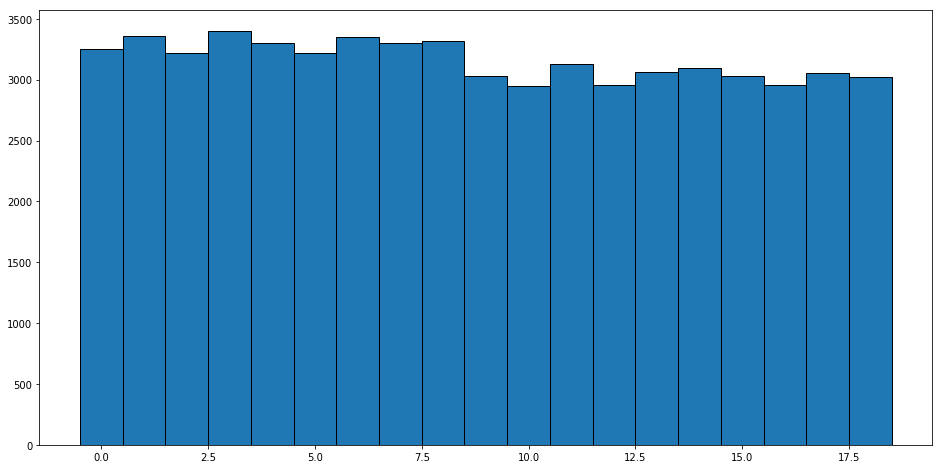

In [324]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
d = np.unique(post_ids)
ax1.hist(post_ids, bins=np.arange(np.max(d)+2)-.5, edgecolor='black')

(array([ 3384.,  3107.,  3375.,  3409.,  3367.,  3394.,  3532.,  3466.,
         3467.,  3405.,  3226.,  3297.,  3125.,  3341.,  3256.,  3256.,
         3300.,  1729.,  1564.]),
 array([ -0.5,   0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,
          8.5,   9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,
         17.5,  18.5]),
 <a list of 19 Patch objects>)

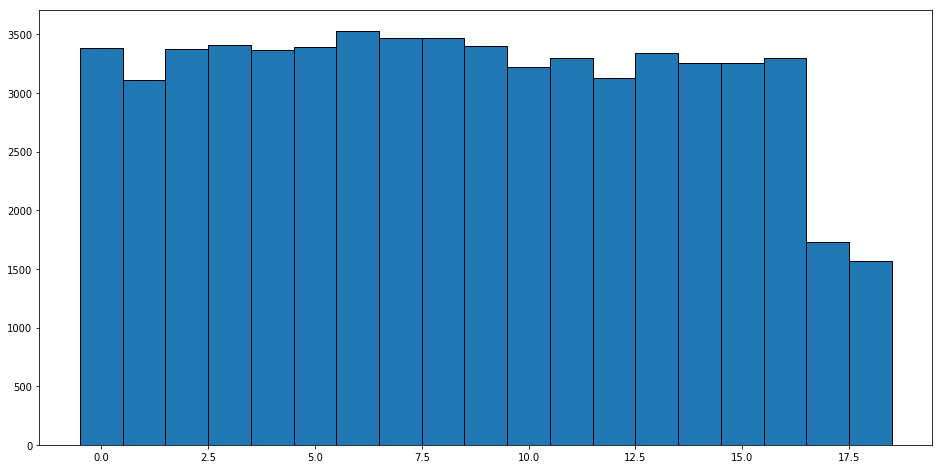

In [325]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
d = np.unique(pre_ids)
ax1.hist(pre_ids, bins=np.arange(np.max(d)+2)-.5, edgecolor='black')

(array([ 0.49405,  0.50595]),
 array([-0.5,  0.5,  1.5]),
 <a list of 2 Patch objects>)

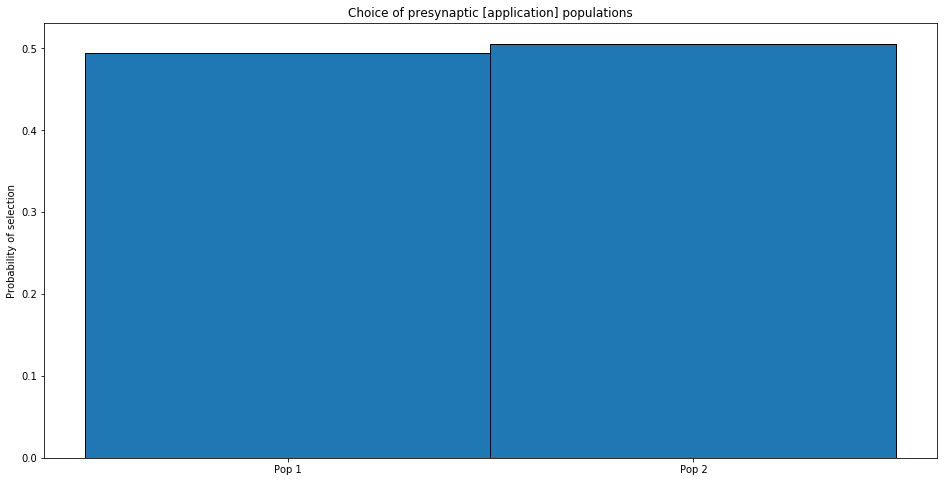

In [349]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
ax1.set_title("Choice of presynaptic [application] populations")
plt.xticks([0, 1], ["Pop 1", "Pop 2"])
ax1.set_ylabel("Probability of selection")
d = np.unique(pre_app_pops)
ax1.hist(pre_app_pops, bins=np.arange(np.max(d)+2)-.5, edgecolor='black', normed=True)

In [327]:
d

array([0, 1])

(array([ 4405.,  4098.,  4110.,  4305.,  4107.,  4229.,  4300.,  4285.,
         4147.,  4397.,  3886.,  4273.,  4472.,  3004.,  1982.]),
 array([ -0.5,   0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,
          8.5,   9.5,  10.5,  11.5,  12.5,  13.5,  14.5]),
 <a list of 15 Patch objects>)

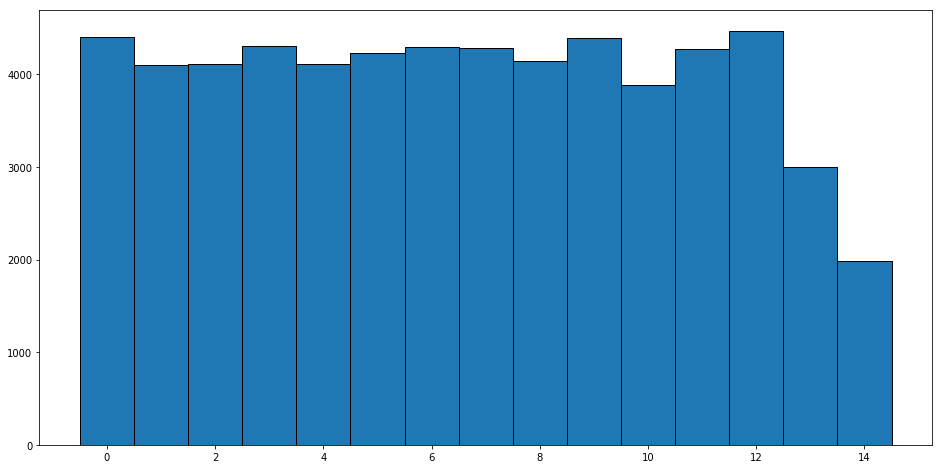

In [328]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
d = np.unique(pre_subpops)
# data = np.asarray(pre_subpops)
# left_of_first_bin = data.min() - float(d)/2
# right_of_last_bin = data.max() + float(d)/2
# plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
ax1.hist(pre_subpops, bins=np.arange(np.max(d)+2)-.5, edgecolor='black')

In [329]:
data = np.asarray(pre_subpops)

In [330]:
data[data==0].size

4405

In [331]:
data[data==1].size

4098

(array([ 206.,  167.,  221.,  231.,  212.,  276.,  267.,  219.,  305.,
         264.,  294.,  267.,  261.,  263.,  199.,  246.,  260.,  214.,
         250.,  203.,  257.,  200.,  237.,  178.,  209.,  239.,  237.,
         276.,  234.,  224.,  237.,  213.,  214.,  271.,  196.,  203.,
         232.,  237.,  264.,  286.,  281.,  320.,  191.,  248.,  242.,
         193.,  208.,  211.,  225.,  182.,  215.,  209.,  235.,  170.,
         217.,  249.,  228.,  262.,  225.,  262.,  257.,  204.,  260.,
         234.,  249.,  263.,  253.,  261.,  207.,  225.,  185.,  278.,
         273.,  248.,  230.,  240.,  236.,  204.,  221.,  221.,  236.,
         197.,  249.,  240.,  202.,  213.,  168.,  263.,  213.,  308.,
         252.,  205.,  181.,  234.,  233.,  216.,  280.,  234.,  241.,
         272.,  254.,  251.,  272.,  230.,  224.,  233.,  246.,  233.,
         221.,  179.,  243.,  198.,  239.,  220.,  214.,  258.,  225.,
         258.,  214.,  268.,  237.,  278.,  275.,  209.,  218.,  208.,
      

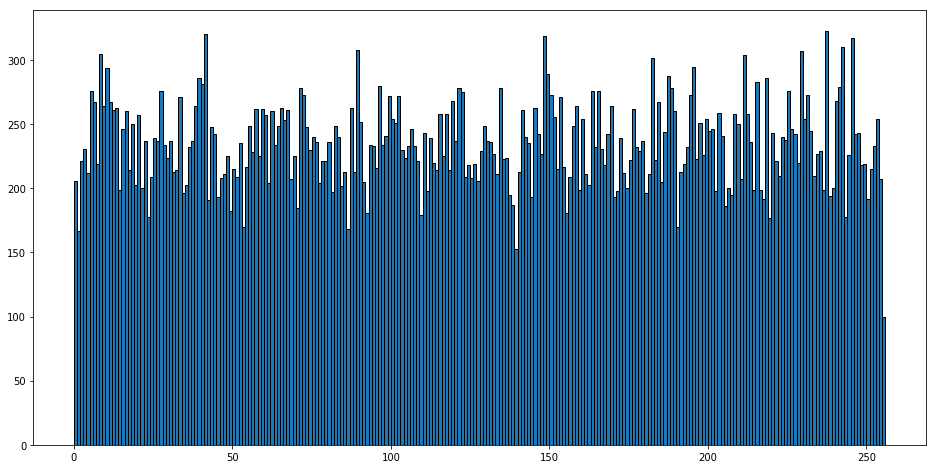

In [332]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
d = np.unique(global_pre_id)
# data = np.asarray(pre_subpops)
# left_of_first_bin = data.min() - float(d)/2
# right_of_last_bin = data.max() + float(d)/2
# plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
ax1.hist(global_pre_id, bins=np.arange(np.max(d)+2), edgecolor='black')

(array([ 230.,  220.,  222.,  231.,  218.,  232.,  214.,  223.,  217.,
         220.,  223.,  242.,  240.,  214.,  260.,  236.,  218.,  258.,
         237.,  226.,  246.,  248.,  233.,  252.,  239.,  247.,  224.,
         261.,  214.,  237.,  221.,  220.,  239.,  207.,  281.,  204.,
         252.,  220.,  251.,  235.,  232.,  242.,  234.,  213.,  232.,
         252.,  230.,  234.,  224.,  211.,  224.,  222.,  242.,  225.,
         240.,  225.,  244.,  208.,  248.,  250.,  242.,  237.,  233.,
         274.,  229.,  232.,  235.,  224.,  232.,  226.,  241.,  225.,
         227.,  227.,  237.,  243.,  270.,  247.,  258.,  247.,  249.,
         225.,  253.,  228.,  248.,  262.,  218.,  236.,  224.,  262.,
         250.,  236.,  216.,  220.,  225.,  243.,  248.,  242.,  247.,
         236.,  248.,  232.,  265.,  255.,  218.,  203.,  261.,  216.,
         247.,  236.,  203.,  241.,  244.,  239.,  238.,  217.,  221.,
         263.,  212.,  227.,  266.,  233.,  235.,  238.,  228.,  252.,
      

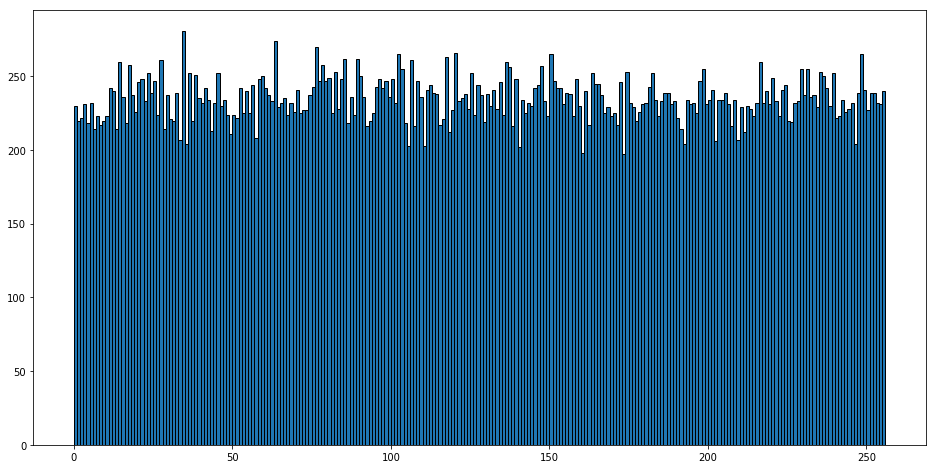

In [333]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
d = np.unique(global_post_id)
# data = np.asarray(pre_subpops)
# left_of_first_bin = data.min() - float(d)/2
# right_of_last_bin = data.max() + float(d)/2
# plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
ax1.hist(global_post_id, bins=np.arange(np.max(d)+2), edgecolor='black')

(array([  217.,   964.,   954.,     0.,   934.,  1860.,     0.,     0.,
          874.,   956.,  1862.,     0.,     0.,  1899.,     0.,     0.,
          983.,  1892.,   908.,     0.,  1900.,     0.,     0.,     0.,
            0.,  2839.,  1887.,     0.,     0.,  1837.,     0.,     0.,
          978.,     0.,  1826.,     0.,   894.,  1964.,     0.,     0.,
         1901.,  1851.,     0.,     0.,     0.,  1953.,     0.,     0.,
            0.,   903.,  2773.,     0.,  1911.,  1837.,     0.,     0.,
            0.,     0.,  1912.,     0.,     0.,  1836.,     0.,     0.,
          458.,  2788.,     0.,     0.,   893.,     0.,     0.,     0.,
          937.,   959.,  1903.,     0.,     0.,     0.,     0.,     0.,
          950.,     0.,     0.,     0.,     0.,  1805.,     0.,     0.,
            0.,   922.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,   951.,     0.,   971.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0., 

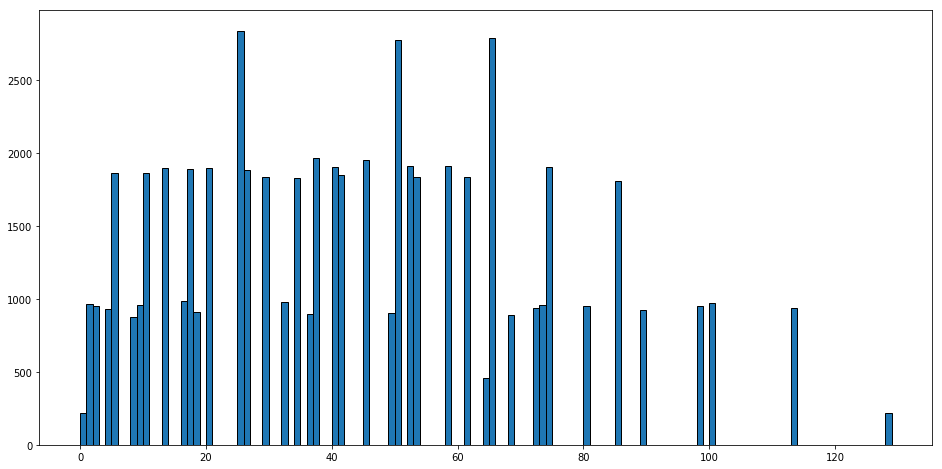

In [334]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
d = np.unique(distance_sq)
# data = np.asarray(pre_subpops)
# left_of_first_bin = data.min() - float(d)/2
# right_of_last_bin = data.max() + float(d)/2
# plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
ax1.hist(distance_sq, bins=np.arange(np.max(d)+2),edgecolor='black')

In [335]:
dist = np.sqrt(distance_sq)
m = np.mean(dist)
std = np.std(dist)

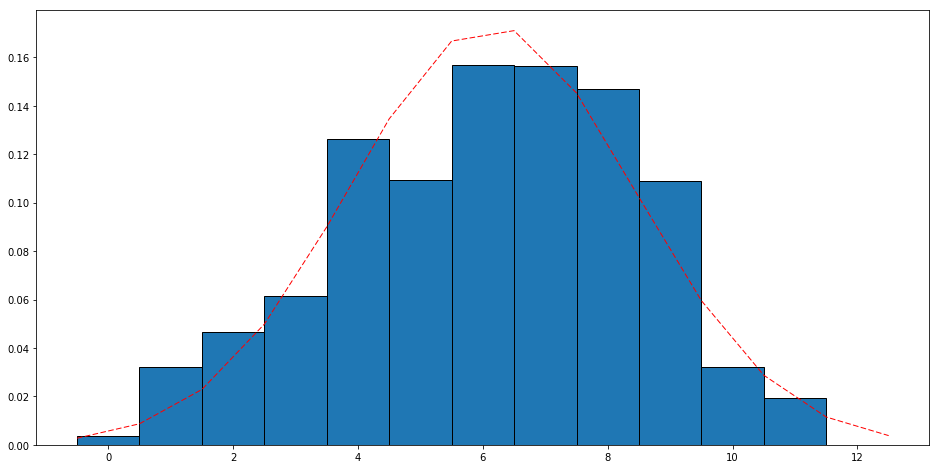

In [336]:
import matplotlib.mlab as mlab
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
d = np.unique(np.sqrt(distance_sq))
# data = np.asarray(pre_subpops)
# left_of_first_bin = data.min() - float(d)/2
# right_of_last_bin = data.max() + float(d)/2
# plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))

n, bins, patches = ax1.hist(np.sqrt(distance_sq), bins=np.arange(np.max(d)+2)-.5,normed=1, edgecolor='black')
y = mlab.normpdf( bins, m, std)
l = ax1.plot(bins, y, 'r--', linewidth=1)

In [337]:
def distance(x0, x1, grid=np.asarray([16, 16]), type='euclidian'):
    x0 = np.asarray(x0)
    x1 = np.asarray(x1)
    delta = np.abs(x0 - x1)
    delta = np.where(delta > grid * .5, delta - grid, delta)

    if type == 'manhattan':
        return np.abs(delta).sum(axis=-1)
    return np.sqrt((delta ** 2).sum(axis=-1))
def index_to_dist(i1, i2, grid):
    return distance((i1//grid[0], i1%grid[1]),(i2//grid[0], i2%grid[1]), grid=grid, type='euclidian')

In [338]:
layer_size = 256
grid_layout = np.asarray((16, 16))

In [339]:
for i in np.arange(global_post_id.size):
    assert np.round(index_to_dist(global_pre_id[i], global_post_id[i], grid_layout)**2) == distance_sq[i]

In [340]:
counts = np.ones((layer_size, layer_size)) * np.nan

In [341]:
for i in np.arange(global_post_id.size):
    if np.isnan(counts[global_pre_id[i], global_post_id[i]]):
        counts[global_pre_id[i], global_post_id[i]] = 1
    else:
        counts[global_pre_id[i], global_post_id[i]] += 1

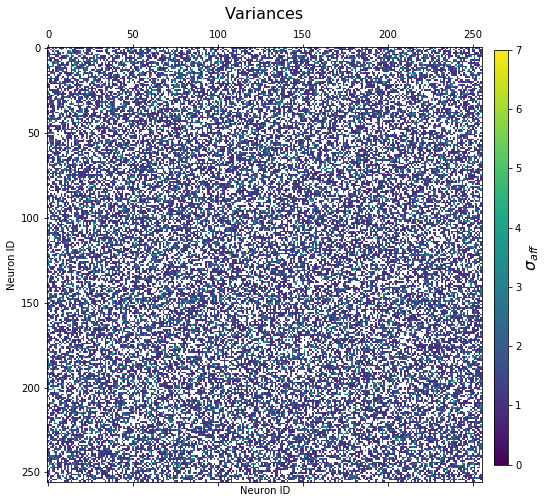

In [342]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(counts, vmin=0)
ax1.grid(visible=False)
ax1.set_title("Variances", fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
# ax1.set_ylim([20, 0])
# ax1.set_xlim([0, 20])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$\sigma_{aff}$", fontsize=16)

In [351]:
print "hit locations", np.count_nonzero(np.isfinite(counts))

hit locations 39459


In [352]:
np.count_nonzero(np.isfinite(counts)) * 100. / counts.size 

60.20965576171875